In [31]:
import numpy as np
import pandas as pd
import geopandas as gpd
import datetime
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import signal

from shapely.geometry import Point

## Emplacement des stations

In [32]:
tableau_stations_file = "../Data/Extraction_Hydro/Seine/Stations.csv"
tableau_stations = pd.read_csv(tableau_stations_file, encoding="UTF-8",
                              delimiter=";")
tableau_stations = gpd.GeoDataFrame(tableau_stations)
n_stations = tableau_stations.shape[0]

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

In [33]:
tableau_stations['geometry'] = tableau_stations.apply(lambda x: Point(float(x['X (m)']), float(x['Y (m)'])), axis = 1)
tableau_stations = tableau_stations.set_crs('EPSG:27572')
tableau_stations = tableau_stations.to_crs(world.crs)
tableau_stations

,Code station,Libelle station,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,Regime influencé,Altitude du zéro de l'échelle,Coordonnées,X (m),Y (m),geometry
0,H0100010,La Seine à Nod-sur-Seine,True,True,True,True,True,True,True,True,True,True,True,pas ou faiblement,248.25,Lambert II Étendu,767439,2309604,POINT (4.57034 47.76448)
1,H0100020,La Seine à Plaines-Saint-Lange,True,True,True,True,True,True,True,True,True,True,True,pas ou faiblement,179.35,Lambert II Étendu,760029,2335130,POINT (4.48082 47.99581)
2,H0400010,La Seine à Bar-sur-Seine,True,True,True,True,True,True,True,True,True,True,True,pas ou faiblement,148.00,Lambert II Étendu,751916,2348365,POINT (4.37676 48.11672)
3,H0400020,La Seine à Courtenot,True,True,True,True,True,True,True,True,True,True,True,pas ou faiblement,0.00,Lambert II Étendu,746950,2351620,POINT (4.31119 48.14712)
4,H0800011,La Seine [partielle] à Troyes [Foicy],True,True,True,True,True,True,True,True,True,True,True,fortement,102.00,Lambert II Étendu,731065,2368493,POINT (4.10290 48.30219)
5,H0800012,La Seine [partielle] à Troyes [Tauxelles],True,True,True,True,True,True,True,True,True,True,True,fortement,100.00,Lambert II Étendu,729271,2369769,POINT (4.07911 48.31402)
6,H0810010,La Seine à Méry-sur-Seine [après création gran...,True,True,True,True,True,True,True,True,True,True,True,fortement,78.00,Lambert II Étendu,714764,2390999,POINT (3.88926 48.50758)
7,H1700010,La Seine à Pont-sur-Seine,True,True,True,True,True,True,True,True,True,True,True,fortement,60.00,Lambert II Étendu,692920,2392352,POINT (3.59406 48.52325)
8,H1940020,La Seine à Bazoches-lès-Bray [station ultrason],False,False,True,True,True,True,True,True,True,True,True,fortement,52.59,Lambert II Étendu,663190,2381000,POINT (3.19008 48.42479)
9,H2900011,La Seine à Montereau-Fault-Yonne [station US],False,False,False,False,True,True,True,True,True,True,True,NaN,45.77,Lambert II Étendu,646210,2376785,POINT (2.96027 48.38833)


<AxesSubplot:>

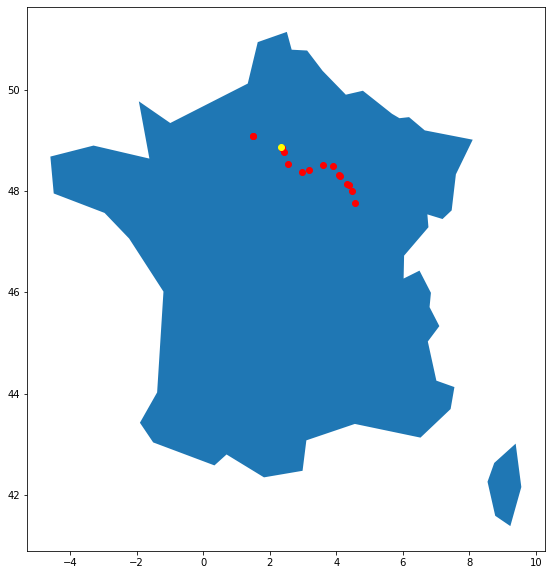

In [34]:
france = world[world['name'] == "France"].geometry.explode()[[1,2]].unary_union

base = gpd.GeoSeries(france).plot(figsize = (10, 10))
tableau_stations.plot(ax = base, color = "red")
cities[cities['name'] == "Paris"].plot(ax = base, color = "yellow")

On trie les stations d'Est en Ouest et du Sud au Nord.

In [35]:
tableau_stations["Ord"] = tableau_stations["geometry"].apply(lambda x: x.coords[:][0][1])
tableau_stations["Abs"] = tableau_stations["geometry"].apply(lambda x: x.coords[:][0][0])

tri = tableau_stations.sort_values(by = "Ord", ascending=True).sort_values(by = "Abs", ascending=False)[["Code station"]]
for i in range(n_stations):
    code = tri["Code station"][i]
    tableau_stations.loc[tableau_stations["Code station"] == code,"Ordre"] = i

station_amont_pt = tableau_stations["geometry"].to_crs("EPSG:32633")[tableau_stations["Ordre"].values.argmin()]
tableau_stations["Distance amont"] = tableau_stations["geometry"].to_crs("EPSG:32633").distance(station_amont_pt)
tableau_stations

,Code station,Libelle station,2010,2011,2012,2013,2014,2015,2016,2017,...,Regime influencé,Altitude du zéro de l'échelle,Coordonnées,X (m),Y (m),geometry,Ord,Abs,Ordre,Distance amont
0,H0100010,La Seine à Nod-sur-Seine,True,True,True,True,True,True,True,True,...,pas ou faiblement,248.25,Lambert II Étendu,767439,2309604,POINT (4.57034 47.76448),47.764483,4.570344,0.0,0.000000
1,H0100020,La Seine à Plaines-Saint-Lange,True,True,True,True,True,True,True,True,...,pas ou faiblement,179.35,Lambert II Étendu,760029,2335130,POINT (4.48082 47.99581),47.995810,4.480821,1.0,26767.769897
2,H0400010,La Seine à Bar-sur-Seine,True,True,True,True,True,True,True,True,...,pas ou faiblement,148.00,Lambert II Étendu,751916,2348365,POINT (4.37676 48.11672),48.116723,4.376762,2.0,42050.557918
3,H0400020,La Seine à Courtenot,True,True,True,True,True,True,True,True,...,pas ou faiblement,0.00,Lambert II Étendu,746950,2351620,POINT (4.31119 48.14712),48.147122,4.311194,3.0,47079.496814
4,H0800011,La Seine [partielle] à Troyes [Foicy],True,True,True,True,True,True,True,True,...,fortement,102.00,Lambert II Étendu,731065,2368493,POINT (4.10290 48.30219),48.302190,4.102904,4.0,69718.123254
5,H0800012,La Seine [partielle] à Troyes [Tauxelles],True,True,True,True,True,True,True,True,...,fortement,100.00,Lambert II Étendu,729271,2369769,POINT (4.07911 48.31402),48.314019,4.079115,5.0,71767.281657
6,H0810010,La Seine à Méry-sur-Seine [après création gran...,True,True,True,True,True,True,True,True,...,fortement,78.00,Lambert II Étendu,714764,2390999,POINT (3.88926 48.50758),48.507577,3.889262,6.0,97662.237498
7,H1700010,La Seine à Pont-sur-Seine,True,True,True,True,True,True,True,True,...,fortement,60.00,Lambert II Étendu,692920,2392352,POINT (3.59406 48.52325),48.523246,3.594062,7.0,112195.357622
8,H1940020,La Seine à Bazoches-lès-Bray [station ultrason],False,False,True,True,True,True,True,True,...,fortement,52.59,Lambert II Étendu,663190,2381000,POINT (3.19008 48.42479),48.424787,3.190077,8.0,127348.707603
9,H2900011,La Seine à Montereau-Fault-Yonne [station US],False,False,False,False,True,True,True,True,...,NaN,45.77,Lambert II Étendu,646210,2376785,POINT (2.96027 48.38833),48.388328,2.960273,9.0,139717.307455


<AxesSubplot:>

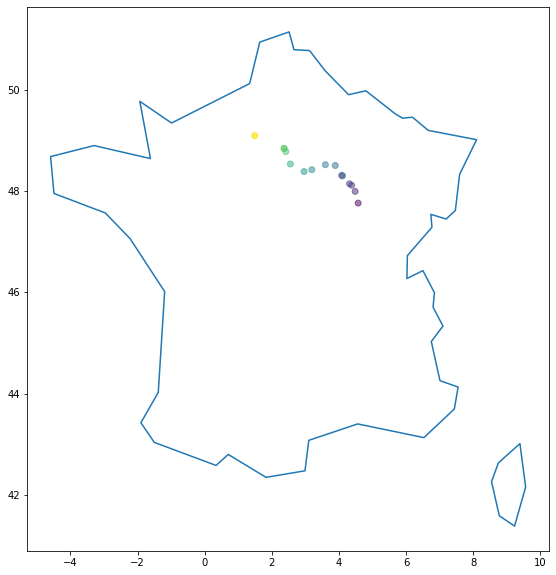

In [36]:
# On a 17 stations
base = gpd.GeoSeries(france).boundary.plot(figsize = (10, 10))
dist_aval = tableau_stations["Distance amont"].values.max()
tableau_stations.plot(ax = base, color = cm.get_cmap("viridis")(tableau_stations["Distance amont"]/dist_aval), alpha = 0.5)

## On rassemble les années

In [37]:
# Initialisation
annees = [a for a in range(2010, 2021)]

for c_annee in annees:
    print(c_annee)
    
    station_dates = tableau_stations["Code station"][tableau_stations[str(c_annee)]][0] #Une station avec cette annee présente
    mesures_annee = pd.read_csv("../Data/Extraction_Hydro/Seine/" + station_dates + "_" + str(c_annee) + ".csv",
                                sep = ";")[["Date"]]
    
    for i in range(n_stations):
        code = tableau_stations[tableau_stations["Ordre"] == i]["Code station"].values[0]
        if tableau_stations[tableau_stations["Ordre"] == i][str(c_annee)].values[0]:
            station = pd.read_csv("../Data/Extraction_Hydro/Seine/" + code + "_" + str(c_annee) + ".csv",
                                  sep = ";")
            station = station.rename(columns = {"Q (m3/s)": code})
            mesures_annee = mesures_annee.merge(station[["Date", code]],
                                                on = "Date",
                                                how = "outer")
        else:
            mesures_annee[code] = None
    
    mesures_annee["Date"] = pd.to_datetime(mesures_annee["Date"], format = "%d/%m/%Y %H:%M")
    mesures_annee = mesures_annee.sort_values(by = "Date")
    mesures_annee.to_csv("../Data/Extraction_Hydro/Seine/Mesures_" + str(c_annee) + ".csv",
                        index = False)

2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


In [38]:
mesures = pd.read_csv("../Data/Extraction_Hydro/Seine/Mesures_2010.csv")
mesures["Date"] = pd.to_datetime(mesures["Date"], format = "%Y/%m/%d %H:%M:%S")

for c_annee in annees[1:]:
    print(c_annee)
    mesures_annee = pd.read_csv("../Data/Extraction_Hydro/Seine/Mesures_" + str(c_annee) + ".csv")
    mesures_annee["Date"] = pd.to_datetime(mesures_annee["Date"], format = "%Y/%m/%d %H:%M:%S")
    mesures = pd.concat([mesures, mesures_annee])
mesures = mesures.sort_values(by = "Date")
mesures.to_csv("../Data/Extraction_Hydro/Seine/Mesures.csv",
                        index = False)

2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


In [39]:
mesures.head()

,Date,H0100010,H0100020,H0400010,H0400020,H0800011,H0800012,H0810010,H1700010,H1940020,H2900011,H3930020,H4340020,H5920011,H5920014,H8100020,H8100021
0,2010-01-01 00:00:00,13.5,25.0,59.9,9.39,25.3,13.7,26.7,55.8,NaN,NaN,308.0,306.0,NaN,488.0,NaN,703.0
1,2010-01-01 02:00:00,13.6,25.1,60.1,9.50,25.0,13.5,27.5,56.6,NaN,NaN,308.0,303.0,NaN,487.0,NaN,710.0
2,2010-01-01 04:00:00,13.7,25.2,60.1,9.60,24.7,13.4,28.3,57.4,NaN,NaN,310.0,302.0,NaN,486.0,NaN,716.0
3,2010-01-01 06:00:00,13.8,25.3,60.1,9.63,24.4,13.3,29.2,58.1,NaN,NaN,312.0,301.0,NaN,485.0,NaN,724.0
4,2010-01-01 08:00:00,13.9,25.3,60.1,9.64,24.2,13.2,29.9,58.7,NaN,NaN,313.0,300.0,NaN,482.0,NaN,742.0


## Explorations

In [40]:
mesures = pd.read_csv("../Data/Extraction_Hydro/Seine/Mesures.csv")
mesures["Date"] = pd.to_datetime(mesures["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures.describe(include = "all")

,Date,H0100010,H0100020,H0400010,H0400020,H0800011,H0800012,H0810010,H1700010,H1940020,H2900011,H3930020,H4340020,H5920011,H5920014,H8100020,H8100021
count,48216,48216.000000,47938.000000,48216.000000,48216.000000,48216.000000,48216.000000,48216.000000,48216.000000,39437.000000,26054.000000,48216.000000,48215.000000,7513.000000,48214.000000,1926.000000,48205.000000
unique,48216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2010-07-31 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,2010-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2020-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,4.367108,10.950432,25.437684,18.113232,16.586164,17.696322,33.215503,76.502812,80.341781,178.696089,213.396771,227.395806,195.097578,324.439067,832.317757,475.742359
std,NaN,6.008709,11.549136,30.792265,20.880031,22.266862,7.712264,27.366666,62.110635,69.936991,156.533842,175.842636,185.248208,90.382218,261.708054,430.758391,345.162003
min,NaN,0.190000,0.850000,0.010000,0.270000,0.640000,3.870000,8.760000,22.900000,8.570000,32.500000,24.900000,0.210000,90.900000,53.200000,169.000000,17.300000
25%,NaN,0.770000,2.960000,4.770000,4.940000,2.430000,12.300000,15.400000,36.000000,32.900000,76.600000,90.600000,96.900000,146.000000,143.000000,415.250000,230.000000


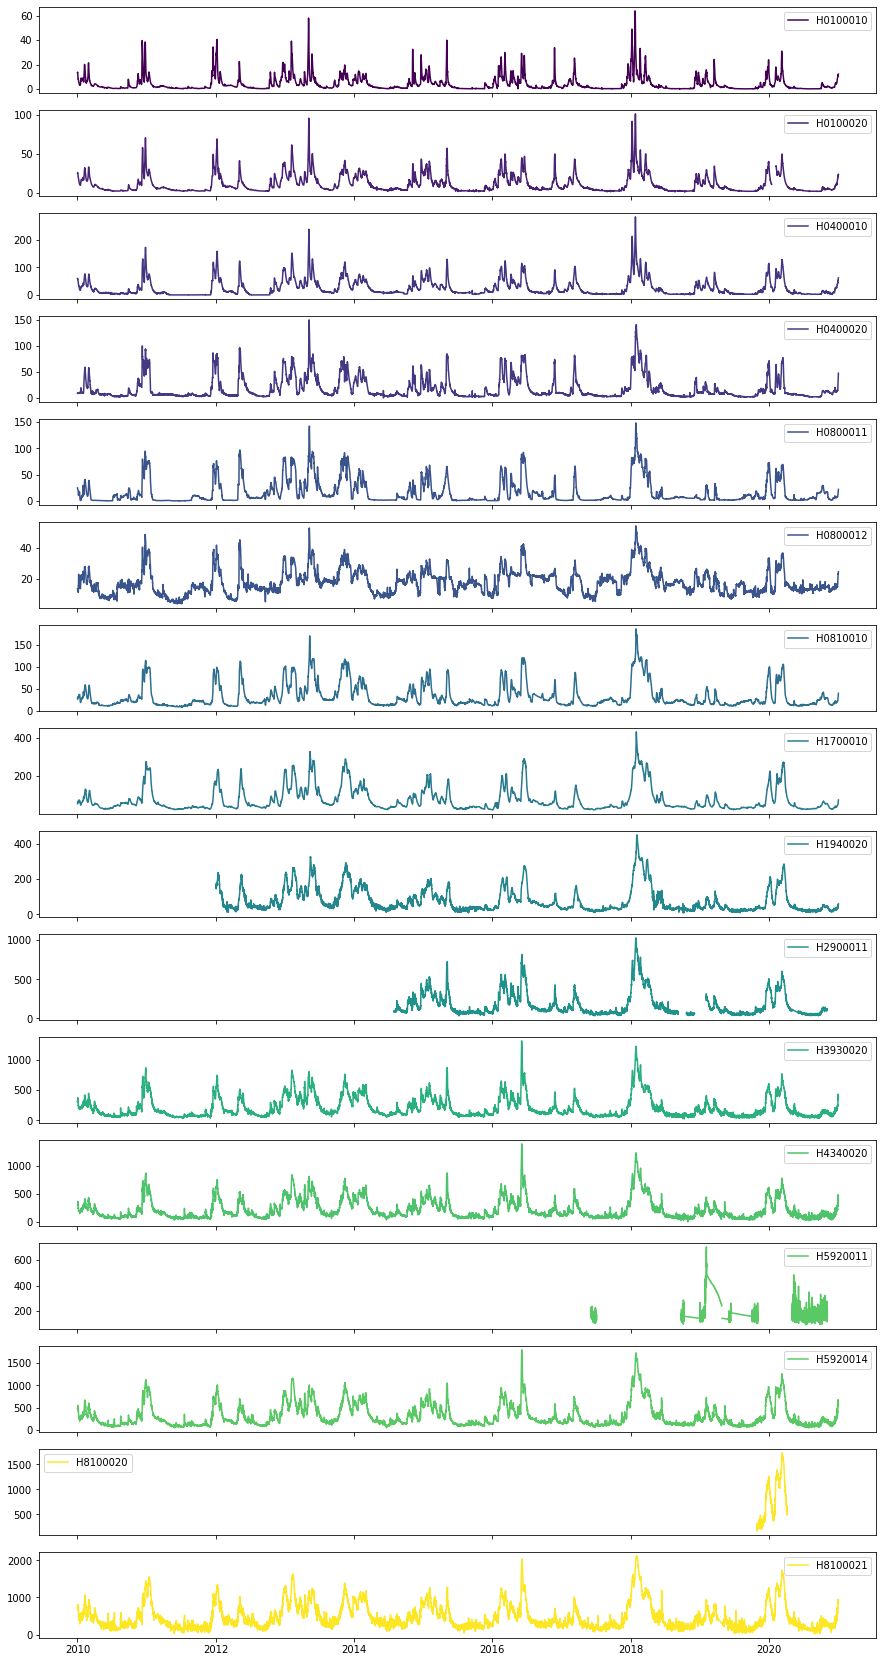

In [41]:
n_stations = tableau_stations.shape[0]
fig, axs = plt.subplots(n_stations, 1, figsize = (15,30), sharex=True)
for i in range(n_stations):
    code = tableau_stations[tableau_stations["Ordre"] == i]["Code station"].values[0]
    axs[i].plot(mesures["Date"], mesures[code], label = code, 
                color = cm.get_cmap("viridis")(tableau_stations.loc[i, "Distance amont"]/dist_aval))
    axs[i].legend()

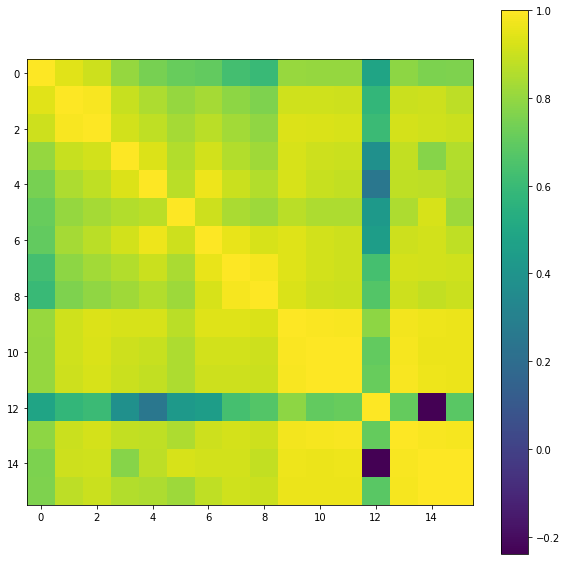

In [42]:
fig, ax = plt.subplots(figsize = (10, 10))
im = ax.imshow(mesures.corr())
fig.colorbar(im)

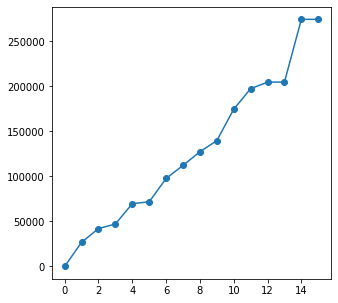

In [43]:
# Voir la répartition les distances
fig, ax = plt.subplots(figsize = (5,5))
ax.plot(tableau_stations["Ordre"], 
        tableau_stations["Distance amont"],
       marker = "o")

## Corrélations croisées

On prend la station amont, une station au milieu (au pif, la numéro 8) et la 16 et on regarde les corrélations croisées.

In [44]:
stations_corr = [tableau_stations[tableau_stations["Ordre"] == 0]["Code station"].values[0],
                 tableau_stations[tableau_stations["Ordre"] == int((n_stations-1)/2)]["Code station"].values[0],
                 tableau_stations[tableau_stations["Ordre"] == n_stations-3]["Code station"].values[0]]
mesures_corr = pd.DataFrame()
mesures_crosscorr = pd.DataFrame()
origine = len(mesures)-1
max_lag = 12*30

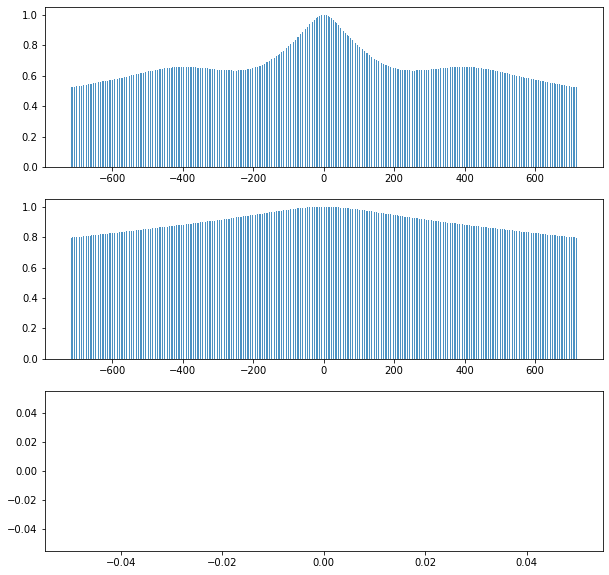

In [45]:
fig, axs = plt.subplots(3, 1, figsize = (10,10))

for i in range(3):
    current_station = stations_corr[i]
    corr= signal.correlate(mesures[current_station], mesures[current_station], mode = "full")
    corr /= np.max(corr)
    mesures_corr[current_station]=corr
    axs[i].bar([2*i for i in range(-max_lag, max_lag+1)],
               corr[(origine-max_lag):(origine+max_lag+1)],
              alpha = 0.8,
               width = 1.,
              log = False)

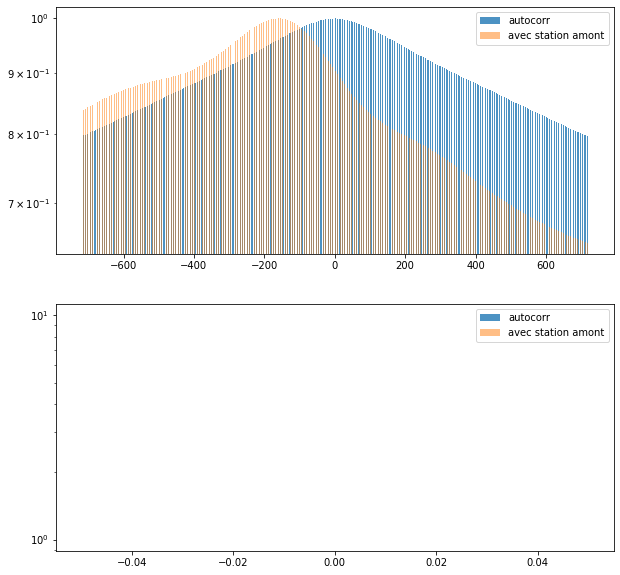

In [46]:
fig, axs = plt.subplots(2, 1, figsize = (10,10))
station_amont = tableau_stations["Code station"][tableau_stations["Ordre"].values.argmin()]

for i in range(1,3):
    current_station = stations_corr[i]
    corr= signal.correlate(mesures[station_amont], mesures[current_station], mode = "full")
    corr /= np.max(corr)
    mesures_crosscorr[current_station]=corr
    axs[i-1].bar([2*i for i in range(-max_lag, max_lag+1)],
               mesures_corr[current_station][(origine-max_lag):(origine+max_lag+1)],
                 label = "autocorr",
                alpha = 0.8,
                 width = 1.0,
                log = True)
    axs[i-1].bar([2*i for i in range(-max_lag, max_lag+1)],
               corr[(origine-max_lag):(origine+max_lag+1)],
                 label = "avec station amont",
                 alpha = 0.5,
                log = True)
    axs[i-1].legend()

## Nettoyage

In [47]:
mesures.describe(include = "all")

,Date,H0100010,H0100020,H0400010,H0400020,H0800011,H0800012,H0810010,H1700010,H1940020,H2900011,H3930020,H4340020,H5920011,H5920014,H8100020,H8100021
count,48216,48216.000000,47938.000000,48216.000000,48216.000000,48216.000000,48216.000000,48216.000000,48216.000000,39437.000000,26054.000000,48216.000000,48215.000000,7513.000000,48214.000000,1926.000000,48205.000000
unique,48216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2010-07-31 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,2010-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2020-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,4.367108,10.950432,25.437684,18.113232,16.586164,17.696322,33.215503,76.502812,80.341781,178.696089,213.396771,227.395806,195.097578,324.439067,832.317757,475.742359
std,NaN,6.008709,11.549136,30.792265,20.880031,22.266862,7.712264,27.366666,62.110635,69.936991,156.533842,175.842636,185.248208,90.382218,261.708054,430.758391,345.162003
min,NaN,0.190000,0.850000,0.010000,0.270000,0.640000,3.870000,8.760000,22.900000,8.570000,32.500000,24.900000,0.210000,90.900000,53.200000,169.000000,17.300000
25%,NaN,0.770000,2.960000,4.770000,4.940000,2.430000,12.300000,15.400000,36.000000,32.900000,76.600000,90.600000,96.900000,146.000000,143.000000,415.250000,230.000000


A priori, on garde les stations avec les mesures complètes

In [48]:
proportion_mesures = mesures.drop("Date", axis = 1).count()/len(mesures)
proportion_mesures

H0100010    1.000000
H0100020    0.994234
H0400010    1.000000
H0400020    1.000000
H0800011    1.000000
H0800012    1.000000
H0810010    1.000000
H1700010    1.000000
H1940020    0.817924
H2900011    0.540360
H3930020    1.000000
H4340020    0.999979
H5920011    0.155820
H5920014    0.999959
H8100020    0.039945
H8100021    0.999772
dtype: float64

In [49]:
stations_complet = []
stations_incomplet = []
for idx, row in proportion_mesures.iteritems():
    if row < 1:
        stations_incomplet.append(idx)
    else:
        stations_complet.append(idx)
stations_incomplet

['H0100020',
 'H1940020',
 'H2900011',
 'H4340020',
 'H5920011',
 'H5920014',
 'H8100020',
 'H8100021']

In [50]:
proportion_mesures[stations_incomplet]

H0100020    0.994234
H1940020    0.817924
H2900011    0.540360
H4340020    0.999979
H5920011    0.155820
H5920014    0.999959
H8100020    0.039945
H8100021    0.999772
dtype: float64

In [51]:
mesures[["Date"] + stations_incomplet]

,Date,H0100020,H1940020,H2900011,H4340020,H5920011,H5920014,H8100020,H8100021
0,2010-01-01 00:00:00,25.0,NaN,NaN,306.0,NaN,488.0,NaN,703.0
1,2010-01-01 02:00:00,25.1,NaN,NaN,303.0,NaN,487.0,NaN,710.0
2,2010-01-01 04:00:00,25.2,NaN,NaN,302.0,NaN,486.0,NaN,716.0
3,2010-01-01 06:00:00,25.3,NaN,NaN,301.0,NaN,485.0,NaN,724.0
4,2010-01-01 08:00:00,25.3,NaN,NaN,300.0,NaN,482.0,NaN,742.0
...,...,...,...,...,...,...,...,...,...
48211,2020-12-31 14:00:00,23.0,58.3,NaN,412.0,NaN,573.0,NaN,940.0
48212,2020-12-31 16:00:00,23.1,57.8,NaN,405.0,NaN,571.0,NaN,928.0
48213,2020-12-31 18:00:00,23.1,60.2,NaN,406.0,NaN,572.0,NaN,936.0
48214,2020-12-31 20:00:00,23.1,60.3,NaN,405.0,NaN,574.0,NaN,933.0


In [52]:
mesures[stations_incomplet].isna().sum()

H0100020      278
H1940020     8779
H2900011    22162
H4340020        1
H5920011    40703
H5920014        2
H8100020    46290
H8100021       11
dtype: int64

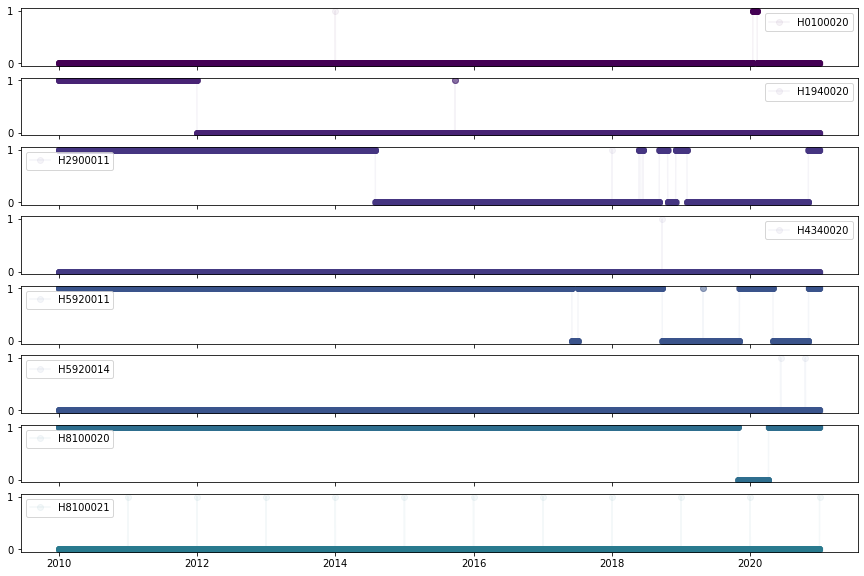

In [53]:
fig, axs = plt.subplots(len(stations_incomplet), 1, figsize = (15,10), sharex=True)
for i in range(len(stations_incomplet)):
    code = stations_incomplet[i]
    axs[i].plot(mesures["Date"], np.isnan(mesures[code]), label = code, 
                color = cm.get_cmap("viridis")(tableau_stations.loc[i, "Distance amont"]/dist_aval), marker = "o", alpha = 0.05)
    axs[i].legend()

On va garder les stations:
- H0100020
- H4340020
- H8100021

In [54]:
stations_interpoler = ["H0100020", "H4340020", "H8100021"]

In [55]:
mesures[["Date"] + stations_interpoler]

,Date,H0100020,H4340020,H8100021
0,2010-01-01 00:00:00,25.0,306.0,703.0
1,2010-01-01 02:00:00,25.1,303.0,710.0
2,2010-01-01 04:00:00,25.2,302.0,716.0
3,2010-01-01 06:00:00,25.3,301.0,724.0
4,2010-01-01 08:00:00,25.3,300.0,742.0
...,...,...,...,...
48211,2020-12-31 14:00:00,23.0,412.0,940.0
48212,2020-12-31 16:00:00,23.1,405.0,928.0
48213,2020-12-31 18:00:00,23.1,406.0,936.0
48214,2020-12-31 20:00:00,23.1,405.0,933.0


In [56]:
for code in stations_interpoler:
    mesures[code] = mesures[code].interpolate()

Les stations au total.

In [57]:
stations_garder = stations_complet + stations_interpoler
stations_garder

['H0100010',
 'H0400010',
 'H0400020',
 'H0800011',
 'H0800012',
 'H0810010',
 'H1700010',
 'H3930020',
 'H0100020',
 'H4340020',
 'H8100021']

In [58]:
tableau_garder = tableau_stations[tableau_stations["Code station"] == stations_garder[0]]
for code in stations_garder[1:]:
    tableau_garder = pd.concat([tableau_garder, tableau_stations[tableau_stations["Code station"] == code]])

# On remet dans l'ordre et garde les colonnes importantes
tableau_garder = tableau_garder.sort_values(by = "Ordre")
tableau_garder["Ordre"] = [i for i in range(tableau_garder.shape[0])]

tableau_garder = tableau_garder[["Code station", "Libelle station", "Regime influencé", "Altitude du zéro de l'échelle", "geometry", "Ordre", ]]
tableau_garder

,Code station,Libelle station,Regime influencé,Altitude du zéro de l'échelle,geometry,Ordre
0,H0100010,La Seine à Nod-sur-Seine,pas ou faiblement,248.25,POINT (4.57034 47.76448),0
1,H0100020,La Seine à Plaines-Saint-Lange,pas ou faiblement,179.35,POINT (4.48082 47.99581),1
2,H0400010,La Seine à Bar-sur-Seine,pas ou faiblement,148.00,POINT (4.37676 48.11672),2
3,H0400020,La Seine à Courtenot,pas ou faiblement,0.00,POINT (4.31119 48.14712),3
4,H0800011,La Seine [partielle] à Troyes [Foicy],fortement,102.00,POINT (4.10290 48.30219),4
5,H0800012,La Seine [partielle] à Troyes [Tauxelles],fortement,100.00,POINT (4.07911 48.31402),5
6,H0810010,La Seine à Méry-sur-Seine [après création gran...,fortement,78.00,POINT (3.88926 48.50758),6
7,H1700010,La Seine à Pont-sur-Seine,fortement,60.00,POINT (3.59406 48.52325),7
10,H3930020,La Seine à Saint-Fargeau-Ponthierry [Sainte-As...,fortement,34.72,POINT (2.55086 48.53713),8
11,H4340020,La Seine à Alfortville,pas ou faiblement,29.46,POINT (2.41782 48.78150),9


In [59]:
tableau_garder.to_csv("../Data/Extraction_Hydro/Stations_Seine.csv",
                        index = False)

In [60]:
mesures_garder = mesures[["Date"] + list(tableau_garder["Code station"])]
mesures_garder.to_csv("../Data/Extraction_Hydro/Mesures_Seine.csv",
                        index = False)